# Advanced Text Analysis with SpaCy and Scikit-Learn

This notebook was originally prepared for the workshop [Advanced Text Analysis with SpaCy and Scikit-Learn](http://dhweek.nycdh.org/event/advanced-text-analysis-with-spacy-and-scikit-learn/), presented as part of NYCDH Week 2017. 

## Installation

This guide assumes you're running Linux or an equivalent operating system. If you're not already running Linux, you can easily download a distribution and copy it to a USB disk, which you can then boot from. I recommend getting [DH-USB](https://github.com/DH-Box/dh-usb), a Linux-based operating system made for the Digital Humanities. DH-USB already has all of this software installed. 

If you have a different Linux-like system, (including, probably, Ubuntu, MacOS, Cygwin, and Bash for Windows), you should be able to run these commands to install SpaCy, Scikit-Learn, Pandas, and the other required libraries: 

```bash
sudo pip install spacy scikit-learn pandas
```

Now download the SpaCy data with this command: 

```bash
python -m spacy.en.download all
```

Note that if your system has Python 2 as the default, instead of Python 3, you might have to run `pip3` instead of `pip`. 

To get my sent2tree library and all the sample data, simply `git clone` the repository where this notebook lives: 

```bash
git clone https://github.com/JonathanReeve/advanced-text-analysis-workshop-2017.git
```

In [492]:
import spacy
import pandas as pd
from collections import Counter
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

# This uses the sent2tree.py file from this directory. 
from sent2tree import sentenceTree

In [493]:
# This command might take a little while. 
nlp = spacy.load('en')

The sample data is the script of the 1975 film _Monty Python and the Holy Grail_, taken from the NLTK Book corpus, and the Project Gutenberg edition of Jane Austen's novel _Pride and Prejudice_. 

In [496]:
grail_raw = open('grail.txt').read()
pride_raw = open('pride.txt').read()

In [497]:
# Parse the texts. These commands might take some time. 
grail = nlp(grail_raw)
pride = nlp(pride_raw)

# Exploring Named Entities

In [495]:
set([w.label_ for w in grail.ents])

{'CARDINAL',
 'DATE',
 'EVENT',
 'GPE',
 'LANGUAGE',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [233]:
[ent for ent in grail.ents if ent.label_ == 'WORK_OF_ART']

[the Holy Pin, the Holy Grail in the Castle of uuggggggh', the Holy Grail]

In [234]:
[ent for ent in grail.ents if ent.label_ == 'GPE']

[England,
 Camelot,
 Mercea,
 Divine,
 Camelot,
 Yeaaah,
 Yeaah,
 Camelot,
 Lancelot,
 Camelot,
 Camelot,
 England,
 Camelot,
 Castle Anthrax,
 Britain,
 Camelot,
 Nador,
 Spring,
 Spring,
 Antioch,
 France,
 Cornwall,
 Assyria]

In [235]:
set(list([ent.string.strip() for ent in grail.ents if ent.label_ == 'ORG']))

{'ARTHUR',
 'Aramaic',
 'Armaments',
 'BEDEVERE',
 'Caerbannog',
 'Camelot',
 'Chicken of Bristol',
 'Excalibur',
 'HISTORIAN',
 'Holy Grail',
 'I.',
 'KNIGHT',
 'Knights',
 'Knights of Ni',
 'Knights of the Round Table',
 'Launcelot',
 'MAN',
 'Olfin Bedwere of',
 'Pie Iesu',
 'Robinson',
 'The Black Knight',
 'The Bridge of Death',
 'The Castle Anthrax',
 'The Holy Hand Grenade of',
 'The Lady of',
 'Uther Pendragon',
 "the BLACK KNIGHT's",
 'the Bridge of Death',
 'the Castle Anthrax',
 'the Court of Camelot',
 'the Holy Grail',
 'the Round Table',
 'the Tall Tower'}

In [236]:
set([ent.string for ent in grail.ents if ent.label_ == 'NORP'])

{'African ',
 'Britons',
 'English ',
 'European ',
 'French',
 'French ',
 'Psalms',
 'Summer',
 'Summer '}

"French" here refers to French _people_, not the French language. We can verify that by getting all the sentences in which this particular type of entity occurs: 

In [260]:
frenchPeople = [ent for ent in grail.ents if ent.label_ == 'NORP' and ent.string.strip() == 'French']
[ent.sent for ent in frenchPeople]

[FRENCH GUARD: I'm French!  ,
 Well, now, uh, Launcelot, Galahad, and I, uh, wait until nightfall, and then leap out of the rabbit, taking the French, uh, by surprise.  ,
 The ferocity of the French taunting took him completely by surprise, and Arthur became convinced that a new strategy was required if the quest for the Holy Grail were to be brought to a successful conclusion.  ,
 So, we French fellows outwit you a second time!,
 So, you think you could out-clever us French folk with your silly knees-bent running about advancing behaviour?!  ,
 ARTHUR: Stand by for attack! [exciting music] [music stops] [silence] French persons!]

# Parts of Speech

First, let's get the noun chunks: 

In [269]:
list(pride.noun_chunks)

[﻿It,
 a truth,
 a single man,
 possession,
 a good fortune,
 want,
 a wife,
 the feelings,
 views,
 such a man,
 a neighbourhood,
 this truth,
 the minds,
 the surrounding families,
 he,
 their daughters,
 “My dear Mr. Bennet,
 his lady,
 him,
 you,
 Netherfield Park,
 Mr. Bennet,
 he,
 it,
 she,
 Mrs. Long,
 she,
 me,
 it,
 Mr. Bennet,
 no answer,
 you,
 who,
 it,
 his wife,
 me,
 I,
 no objection,
 it,
 invitation,
 you,
 Mrs. Long,
 Netherfield,
 a young man,
 large fortune,
 the north,
 England,
 he,
 Monday,
 a chaise,
 the place,
 it,
 he,
 Mr. Morris,
 he,
 possession,
 Michaelmas,
 his servants,
 the house,
 the end,
 next week,
 What,
 his name,
 Bingley,
 he,
 A single man,
 large fortune,
 What,
 our girls,
 it,
 them,
 My dear Mr. Bennet,
 his wife,
 you,
 You,
 I,
 them,
 his design,
 Design,
 you,
 it,
 he,
 love,
 them,
 you,
 him,
 he,
 I,
 no occasion,
 You,
 the girls,
 you,
 them,
 themselves,
 you,
 them,
 Mr. Bingley,
 you,
 the
 party,
 you,
 me,
 I,
 my share,
 

First, what's the distribution of parts of speech in these two texts? 

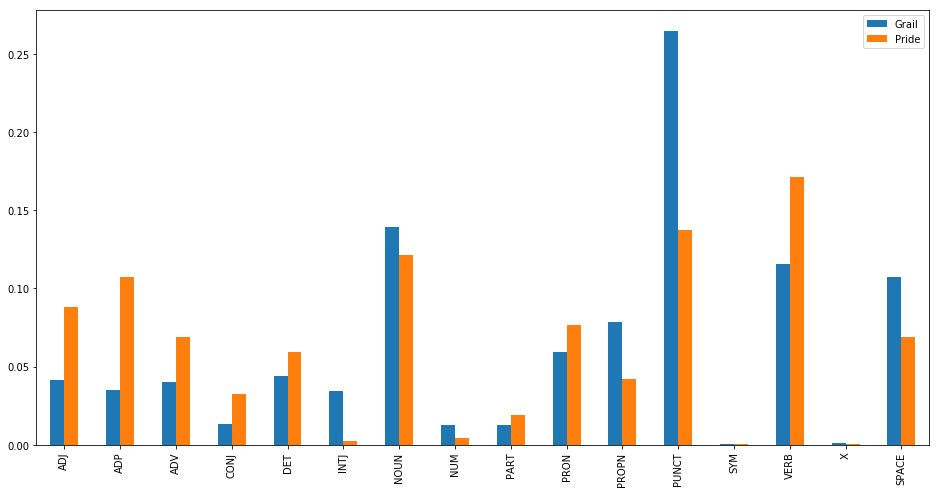

In [293]:
grailPOS = pd.Series(grail.count_by(spacy.attrs.POS))/len(grail)
pridePOS = pd.Series(pride.count_by(spacy.attrs.POS))/len(pride)
df = pd.DataFrame([grailPOS, pridePOS], index=['Grail', 'Pride'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

Now we can see, for instance, what the most common punctuation marks might be. 

In [302]:
prideAdjs = [w for w in pride if w.pos_ == 'PUNCT']
Counter([w.string.strip() for w in prideAdjs]).most_common(10)

[(',', 9129),
 ('.', 4984),
 ('“', 1762),
 ('”', 1713),
 (';', 1533),
 ('!', 478),
 ('?', 455),
 ('-', 327),
 ('--', 307),
 ('_', 299)]

In [303]:
grailAdjs = [w for w in grail if w.pos_ == 'PUNCT']
Counter([w.string.strip() for w in grailAdjs]).most_common(10)

[(':', 1193),
 ('.', 839),
 ('!', 830),
 (',', 745),
 ('[', 320),
 (']', 320),
 ('?', 223),
 ('--', 146),
 ('...', 125),
 ("'", 100)]

Let's try this on the level of a sentence. First, let's get all the sentences in which Sir Robin is explicitly mentioned: 

In [498]:
robinSents = [sent for sent in grail.sents if 'Sir Robin' in sent.string]
robinSents

[The wise Sir Bedevere was the first to join King Arthur's knights, but other illustrious names were soon to follow: Sir Lancelot the Brave; Sir Gallahad the Pure; and Sir Robin the-not-quite-so-brave-as-Sir-Lancelot, who had nearly fought the Dragon of Angnor, who had nearly stood up to the vicious Chicken of Bristol, and who had personally wet himself at the Battle of Badon Hill; and the aptly named Sir Not-appearing-in-this-film.  ,
 The Tale of Sir Robin.  ,
 Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.,
 MINSTREL: [singing] Bravely bold Sir Robin, rode forth from Camelot.  ,
 He was not afraid to die, O brave Sir Robin.  ,
 Brave, brave, brave, brave Sir Robin!  ,
 To have his kneecaps split, and his body burned away, And his limbs all hacked and mangled, brave Sir Robin!,
 He is brave Sir Robin, brave Sir Robin, who--
 ROBIN: Shut up!  ,
 He's scarper
 MINSTREL: [singing] Brave Sir Robin ran away.,
 Yes, brave Sir Robin turned abo

Now let's analyze just one of these sentences.

In [134]:
r2 = robinSents[2]
r2

Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.

Let's look at the tags and parts of speech: 

In [500]:
for word in r2: 
    print(word, word.tag_, word.pos_)

Sir NNP PROPN
Robin NNP PROPN
rode VBD VERB
north NN NOUN
, , PUNCT
through IN ADP
the DT DET
dark JJ ADJ
forest NN NOUN
of IN ADP
Ewing NNP PROPN
, , PUNCT
accompanied VBN VERB
by IN ADP
his PRP$ ADJ
favorite JJ ADJ
minstrels NNS NOUN
. . PUNCT

 SP SPACE


# Dependency Parsing
Now let's analyse the structure of the sentence. 

This sentence has lots of properties: 

In [501]:
[prop for prop in dir(r2) if not prop.startswith('_')]

['doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'has_vector',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'merge',
 'noun_chunks',
 'orth_',
 'rights',
 'root',
 'sent',
 'sentiment',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'text',
 'text_with_ws',
 'vector',
 'vector_norm']

To drill down into the sentence, we can start with the root: 

In [502]:
r2.root

rode

That root has children: 

In [503]:
list(r2.root.children)

[Robin, north, ,, through, accompanied, .]

Let's see all of the children for each word:  

In [505]:
for word in r2: 
    print(word, ': ', str(list(word.children)))

Sir :  []
Robin :  [Sir]
rode :  [Robin, north, ,, through, accompanied, .]
north :  []
, :  []
through :  [forest]
the :  []
dark :  []
forest :  [the, dark, of, ,]
of :  [Ewing]
Ewing :  []
, :  []
accompanied :  [by]
by :  [minstrels]
his :  []
favorite :  []
minstrels :  [his, favorite]
. :  [
]

 :  []


This is very messy-looking, so let's create a nicer visualization. Here I'll be using a class I wrote called sentenceTree, available in the `sent2tree` module in this repository. It just shoehorns a SpaCy span (sentence or other grammatical fragment) into a tree that can be read by the ete3 library for handling trees. This library just allows for some pretty visualizations of trees. 

Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.



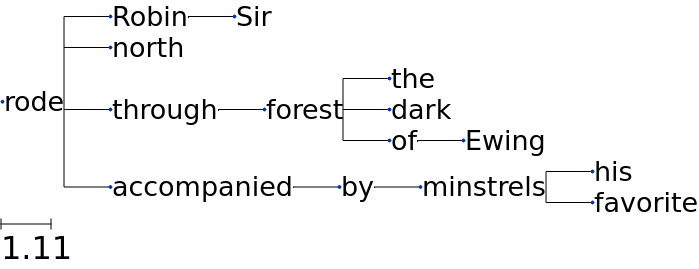

In [506]:
st = sentenceTree(r2)
t, ts = st.render()
t.render('%%inline', tree_style=ts)

You can already see how useful this might be. Since adjectives are typically children of the things they describe, we can get approximations for adjectives that describe characters. How is Sir Robin described? 

In [507]:
for sent in robinSents: 
    for word in sent: 
        if 'Robin' in word.string: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)

bold
brave
brave
brave
brave
brave
brave
brave


Looks like we shouldn't always trust syntactic insight! Now let's do something similar for Pride and Prejudice. First, we'll use named entity extraction to get a list of the most frequently mentioned characters:  

In [508]:
Counter([w.string.strip() for w in pride.ents if w.label_ == 'PERSON']).most_common(10)

[('Elizabeth', 587),
 ('Darcy', 310),
 ('Bennet', 264),
 ('Jane', 259),
 ('Bingley', 200),
 ('Collins', 179),
 ('Wickham', 166),
 ('Lydia', 128),
 ('Lizzy', 92),
 ('Gardiner', 87)]

Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find: 

In [509]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in pride.sents if character in sent.string]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children: 
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

We'll try it on Mr. Darcy: 

In [510]:
adjectivesDescribingCharacters(pride, 'Darcy')

[('late', 6),
 ('present', 2),
 ('disappointing', 1),
 ('abominable', 1),
 ('poor', 1),
 ('handsome', 1),
 ('little', 1),
 ('disagreeable', 1)]

Now let's do the same sort of thing, but look for associated verbs. First, let's get all the sentences in which Elizabeth is mentioned:  

In [511]:
elizabethSentences = [sent for sent in pride.sents if 'Elizabeth' in sent.string]
# And we can peek at one: 
elizabethSentences[3]

Mr. Darcy walked off; and Elizabeth
remained with no very cordial feelings toward him.

In [512]:
st = sentenceTree(elizabethSentences[3])
t, ts = st.render()
t.render('%%inline', tree_style=ts)

Mr. Darcy walked off; and Elizabeth
remained with no very cordial feelings toward him.


NewickError: Empty leaf node found

In [514]:
st.newick

'((Mr.)Darcy,off,and,(()Elizabeth,((no,(very)cordial,(him)toward)feelings)with)remained)walked;'

Now let's write a function that can walk up the dependency tree from a character's name until we get to the first verb. We'll use lemmas instead of the conjugated forms. 

In [201]:
def verbsForCharacters(text, character):
    sents = [sent for sent in pride.sents if character in sent.string]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [202]:
elizabethVerbs = verbsForCharacters(pride, 'Elizabeth')
elizabethVerbs

[('be', 186),
 ('say', 66),
 ('have', 32),
 ('see', 24),
 ('cry', 24),
 ('reply', 22),
 ('feel', 20),
 ('make', 19),
 ('look', 18),
 ('receive', 10),
 ('think', 10),
 ('take', 10),
 ('find', 10),
 ('give', 10),
 ('begin', 9),
 ('walk', 8),
 ('listen', 8),
 ('turn', 8),
 ('help', 8),
 ('pass', 7)]

In [204]:
darcyVerbs = verbsForCharacters(pride, 'Darcy')
janeVerbs = verbsForCharacters(pride, 'Jane')

We can now merge these counts into a single table, and then we can visualize it with Pandas. 

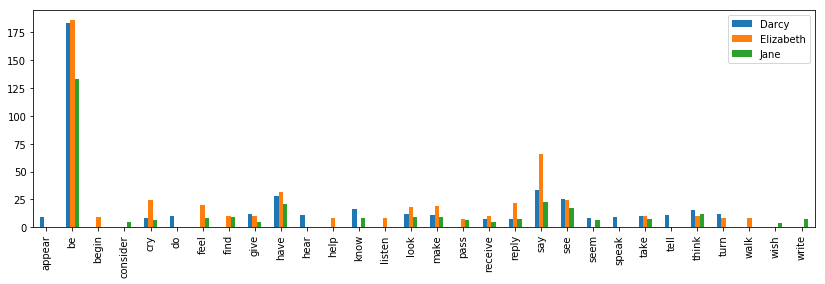

In [205]:
elizabethDict = {t[0]: t[1] for t in elizabethVerbs}
darcyDict = {t[0]: t[1] for t in darcyVerbs}
janeDict = {t[0]: t[1] for t in janeVerbs}
verbsDF = pd.DataFrame({'Elizabeth': pd.Series(elizabethDict), 
                        'Darcy': pd.Series(darcyDict), 
                        'Jane': pd.Series(janeDict)}).fillna(0)
verbsDF.plot(kind='bar', figsize=(14,4))

# Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document. Let's see what the distribution is like: 

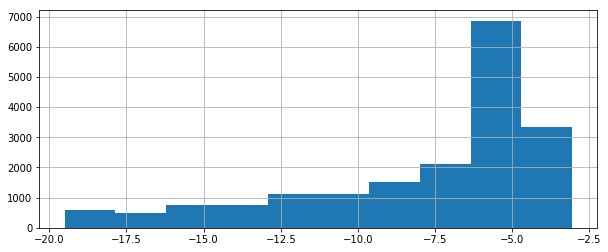

In [211]:
probabilities = [word.prob for word in grail] 
pd.Series(probabilities).hist(figsize=(10,4))

Now we can inspect some of the improbable words: 

In [212]:
set([word.string.strip().lower() for word in grail if word.prob < -19.5])

{'aaaaugh',
 'aaauggh',
 'aaaugh',
 'aaauugh',
 'aaggggh',
 'aaugh',
 'aauuggghhh',
 'aauuugh',
 'aauuuuugh',
 'aauuuves',
 'anging',
 'angnor',
 'animator',
 'auuuuuuuugh',
 'bedevere',
 'bedwere',
 'bors',
 'bridgekeeper',
 'camaaaaaargue',
 'chickennn',
 'clllank',
 'concorde',
 'crapper',
 'crone',
 'defeator',
 'donaeis',
 'drilllll',
 'ector',
 'eisrequiem',
 'enchanter',
 'erbert',
 'fwump',
 'goodem',
 'headoff',
 'hiyaah',
 'hiyya',
 'huyah',
 'hyy',
 'iiiiives',
 'iiiives',
 'loimbard',
 'mercea',
 'minstrel',
 'mooooooo',
 'nador',
 'neee',
 'niggets',
 'ninepence',
 'nnniggets',
 'nnnnniggets',
 'olfin',
 'oooohoohohooo',
 'owli',
 'patsy',
 'pikang',
 'ptoo',
 'pweeng',
 'rewr',
 'rheged',
 'sawwwww',
 "saying,'o",
 'shrubber',
 'shrubberies',
 'thpppppt',
 'thppppt',
 'thpppt',
 'thppt',
 'thsss',
 'thwonk',
 'twong',
 'ulk',
 'umhm',
 'ungallant',
 'unsingable',
 'uuggggggh',
 'varletesses',
 'yapping',
 'zhiv',
 'zoosh',
 'zoot'}

What are those words for _Pride and Prejudice_? 

In [213]:
set([word.string.strip().lower() for word in pride if word.prob < -19.5 and word.is_alpha])

{'abominate',
 'acutest',
 'adieus',
 'affectation',
 'allurements',
 'annesley',
 'appertain',
 'archly',
 'archness',
 'arrear',
 'asperity',
 'barbarously',
 'barouche',
 'bewailed',
 'bingley',
 'bingleys',
 'blowsy',
 'bourgh',
 'breakfasted',
 'brooking',
 'cambric',
 'campful',
 'cassino',
 'chamberlayne',
 'collinses',
 'comfortless',
 'communicativeness',
 'complied',
 'composedly',
 'conciliating',
 'connubial',
 'consoled',
 'contrariety',
 'conversible',
 'coquetry',
 'curricle',
 'curtseyed',
 'decamping',
 'decorums',
 'designedly',
 'desponding',
 'diffuseness',
 'discompose',
 'discomposed',
 'discomposure',
 'discontentedness',
 'disinterestedness',
 'dismission',
 'disobliging',
 'doubtingly',
 'dovedale',
 'ensigncy',
 'equipage',
 'expostulation',
 'feelingly',
 'fitzwilliam',
 'flutterings',
 'forbore',
 'forsters',
 'foxhounds',
 'fretfully',
 'fretfulness',
 'gaieties',
 'gamester',
 'gentlemanlike',
 'gouldings',
 'gracechurch',
 'grantley',
 'gratulation',
 'ha

In [121]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.string.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [123]:
grailGrams = set(ngrams(grail, 3))

In [125]:
for gram in grailGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(Agh, Ni, Ni)
(lapin, lapin, de)
(Pie, Iesu, domine)
(Say, Ecky, ecky)
(ecky, ecky, ecky)
(Camelot, Hurry, Sir)
(Idiom, sir, Idiom)
(Charge, squeak, squeak)
(Hee, hee, hee)
(clop, clop, Ooh)
(Thou, hast, vouchsafed)
(Quoi, Fetchez, la)
(rrrr, drilllll, sawwwww)
(supports, whop, clunk)
(squeak, squeak, squeak)
(clop, clop, clop)
(eis, requiem, Heh)
(Iesu, domine, dona)
(Iesu, domine, bonk)
(pansy, clang, Huyah)
(dona, eis, requiem)
(French, fellows, outwit)
(badger, clank, twong)
(requiem, Pie, Iesu)
(Hyy, Hya, Hiyya)
(domine, bonk, dona)
(mer, Hah, clunk)
(Ni, Ni, Ni)
(rewr, Old, crone)
(Aaaugh, Aaaugh, Augh)
(vache, Quoi, Fetchez)
(sir, fwump, Concorde)
(haw, haw, Ha)
(Halt, horn, Hallo)
(Pie, Iesu, domine)
(boom, pweeng, boom)
(Right, Yeaaah, Yeaah)
(relics, Brother, Maynard)
(squeak, squeak, squeak)
(on, Concorde, thwonk)
(Ecky, ecky, ecky)
(la, vache, Quoi)
(pweeng, boom, boom)
(Tim, Quite, pweeng)
(eis, requiem, witch)
(squeak, squeak, Aaaaugh)
(Woa, wayy, twang)
(Ni, Shh, Shh)
(d

In [126]:
for gram in set(ngrams(pride, 3)): 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(ladyship, wants, Darcy)
(solaced, their, wretchedness)
(replied, Kitty, fretfully)
(Bingley, Jane, met)
(Miss, de, Bourgh)
(gracious, cried, Bennet)
(quitted, Netherfield, last)
(doings, discomposed, Bennet)
(manners, indicated, respectability)
(Catherine, de, Bourgh)
(Blenheim, Warwick, Kenilworth)
(Longbourn, or, Netherfield)
(felicity, nor, humbled)
(Bingley, inattention, After)
(Pemberley, and, Lambton)
(Bourgh, footstool, that)
(satin, curtains, Gardiner)
(Miss, Bingley, vexed)
(Darcy, shameful, boast)
(still, inflexibly, studious)
(observing, Bingley, attentions)
(Longbourn, estate, whenever)
(Elizabeth, dwelling, emphatically)
(Gardiner, left, Longbourn)
(Bennet, eagerly, disclaimed)
(de, Bourgh, widow)
(Bingley, witticisms, on)
(Miss, Bennets, alone)
(Miss, Darcy, delight)
(intrepidity, Miss, Elizabeth)
(till, Elizabeth, recollected)
(creditable, gentlemanlike, set)
(Longbourn, Elizabeth, listened)
(Warwick, Kenilworth, Birmingham)
(Lewis, de, Bourgh)
(anticipated, Miss, Darcy

# Word Embeddings (Word Vectors)

Word embeddings (word vectors) are numeric representations of words, usually generated via dimensionality reduction on a word cooccurrence matrix for a large corpus. The vectors SpaCy uses are the [GloVe](http://nlp.stanford.edu/projects/glove/) vectors, Stanford's Global Vectors for Word Representation. These vectors can be used to calculate semantic similarity between words and documents.

In [214]:
coconut, af_swallow, eu_swallow, horse = nlp('coconut'), nlp('African Swallow'), nlp('European Swallow'), nlp('horse')

In [215]:
coconut.similarity(horse)

0.15660886865377041

In [216]:
af_swallow.similarity(horse)

0.33525863407350248

In [217]:
af_swallow.similarity(eu_swallow)

0.85963767802014357

Let's look at vectors for _Pride and Prejudice_. First, let's get the first 150 nouns:

In [228]:
prideNouns = [word for word in pride if word.pos_.startswith('N')][:150]

Now let's get vectors and labels for each of them: 

In [229]:
prideNounVecs = [word.vector for word in prideNouns]
prideNounLabels = [word.string.strip() for word in prideNouns]

A single vector is 300-dimensional, so we'll have to reduce the dimensionality. We can use truncated singular value decomposition for latent semantic analysis (LSA). 

In [230]:
lsa = TruncatedSVD(n_components=2)
lsaOut = lsa.fit_transform(prideNounVecs)

Plot the results in a scatter plot: 

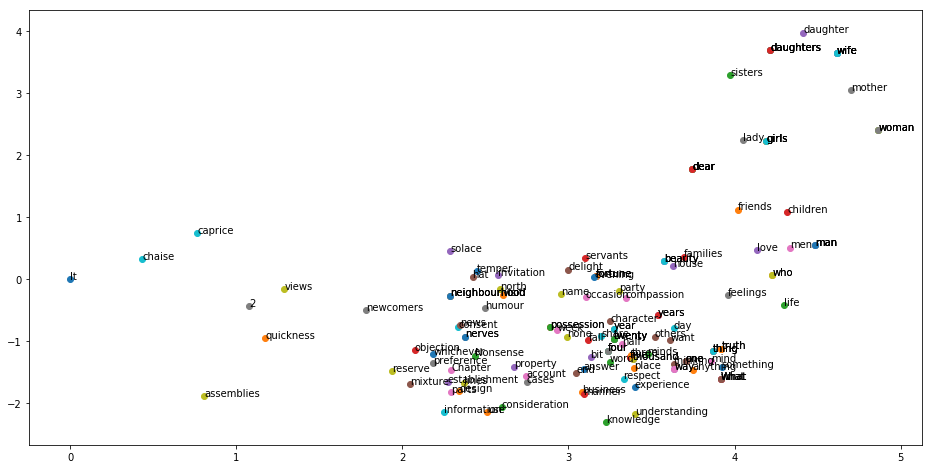

In [231]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
rcParams['figure.figsize'] = 16, 8
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i])
    plt.annotate(prideNounLabels[i], (xs[i], ys[i]))

# Document Vectorization

This uses a non-semantic technique for vectorizing documents, just using bag-of-words. We won't need any of the fancy features of SpaCy for this, just scikit-learn. We'll use a subset of the Inaugural Address Corpus that contains 20th and 21st century inaugural addresses. 

First, we'll vectorize the corpus using scikit-learn's `TfidfVectorizer` class. This creates a matrix of word frequencies. (It doesn't actually use TF-IDF, since we're turning that off in the options below.)

In [451]:
tfidf = TfidfVectorizer(input='filename', decode_error='ignore', use_idf=False)

In [479]:
inauguralFilenames = sorted(glob('inaugural/*'))
# Make labels by removing the directory name and .txt extension: 
labels = [filename.split('/')[1] for filename in inauguralFilenames]
labels = [filename.split('.')[0] for filename in labels]
# While we're at it, let's make a list of the lengths, so we can use them to plot dot sizes. 
lengths = [len(open(filename, errors='ignore').read())/100 for filename in inauguralFilenames]
# Add a manually compiled list of presidential party affiliations. 
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrbr'

In [480]:
data = tfidf.fit_transform(inauguralFilenames)

In [481]:
data.shape

(29, 6177)

In [482]:
lsaOut = lsa.fit_transform(data.todense())

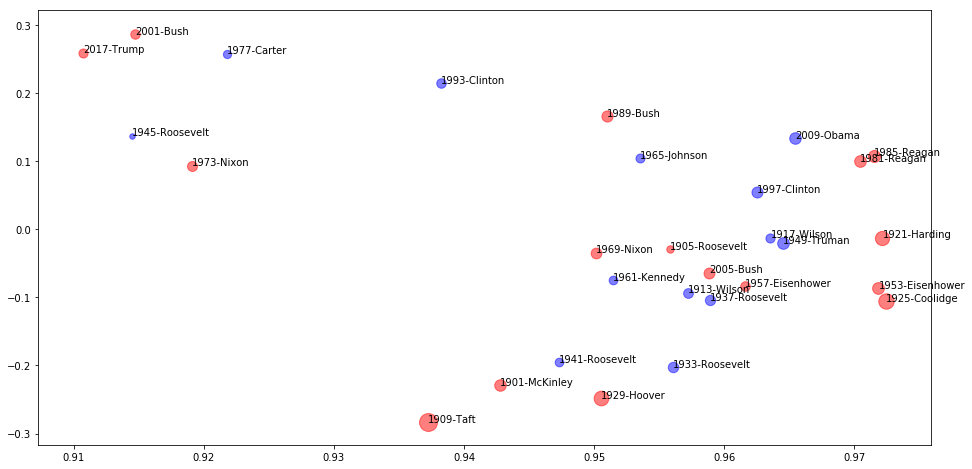

In [484]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], c=parties[i], s=lengths[i], alpha=0.5)
    plt.annotate(labels[i], (xs[i], ys[i]))